In [2]:
# https://otexts.com/fpp3/prophet.html
# Load required libraries. Make sure to install them too
library(readxl)
library(dplyr)
library(Rcpp)
library(ggplot2)
library(lubridate)
library(forecast)
library(prophet)
library(Metrics)
library(zoo) # use for date formatting 
library(stats) # use for additive
library(caret)
library(glmnet)
library(fredr)
#library(tidyverse)




Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: rlang


Attaching package: ‘Metrics’


The following object is masked from ‘package:rlang’:

    ll


The following object is masked from ‘package:forecast’:

    accuracy



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: lattice


Attaching package: ‘caret’


The following objects are masked from ‘package:Metrics’:

    precision, recall


Loading re

In [3]:
# Extract deposit_levels to use it in this file
deposits <- readRDS("/workspaces/DUKE_MIDS_QFC_Final_Project/model_prediction/deposits.rds") # Load the data
deposits$date <- deposits$time_as_date


In [4]:
# Extract regressors_data to use it in this file
regressors_data <- readRDS("/workspaces/DUKE_MIDS_QFC_Final_Project/data_cleaning/regressors_data.rds")

In [5]:
# Extract regressors_data to use it in this file
prediction_data_2 <-readRDS("/workspaces/DUKE_MIDS_QFC_Final_Project/model_prediction/prediction_data_2.rds")


In [6]:
# Take in quaterly deposits of 2025 (from prediction made by XGboost)

# Step 2: Total annual deposit for 2025
deposits_2025_year <- prediction_data_2$yhat[prediction_data_2$ds == as.Date("2025-10-01")] #  Q4 figure would represent deposits at the end of the year (a point-in-time total).
deposits_2025_year

Warning message in check_tzones(e1, e2):
“'tzone' attributes are inconsistent”


[1] 362328333050

In [7]:
# Create a linear regression model to asssess the relationship (sensitivity=coefficient) of different factors on the deposit 

# Step 1: Fetch the regressors online: fed_rate (FEDFUNDS), unemployment_rate (UNRATE), consumer_price_index (UMCSENT), GDP, NASDAQ (NASDAQCOM), (U.S. National Home Price Index) CSUSHPINSA.
# NOTE: use change rate for all the indicators to capture the reaction to shifts in rates and not the plain absolute value

  # FRED API KEY: 4bb02eefc8f7c17a772e030373156e50
fredr_set_key("4bb02eefc8f7c17a772e030373156e50")

  # Define the time range
start_date <- as.Date("1984-01-01")
end_date <- as.Date("2024-04-01")

  # Fetch federal funds rate data
fed_funds <- fredr(
  series_id = "FEDFUNDS",
  observation_start = start_date,
  observation_end = end_date,
  frequency = "q",
  units = "pch"
)
fed_funds <- fed_funds %>%
  rename(federal_rate = value)

  # Fetch unemployment rate data
unemployment <- fredr(
  series_id = "UNRATE",
  observation_start = start_date,
  observation_end = end_date,
  frequency = "q",
  units = "pch"

)
unemployment <- unemployment %>%
  rename(unemployment_rate = value)

  # Fetch consumer_price_index (UMCSENT)

CPI <- fredr(
  series_id = "UMCSENT",
  observation_start = start_date,
  observation_end = end_date,
  frequency = "q",
  units = "pch"

)
CPI <- CPI %>%
  rename(CPI = value)

   # Fetch GDP rate data
GDP <- fredr(
  series_id = "GDP",
  observation_start = start_date,
  observation_end = end_date,
  frequency = "q",
  units = "pch"

)
GDP <- GDP %>%
  rename(gdp_rate = value)


   # Fetch NASDAQ rate data
NASDAQ <- fredr(
  series_id = "NASDAQCOM",
  observation_start = start_date,
  observation_end = end_date,
  frequency = "q",
  units = "pch"
)
NASDAQ <- NASDAQ %>%
  rename(NASDAQ_value = value)

   # Fetch Case-Shiller Home Price Index rate data
housing <- fredr(
  series_id = "CSUSHPINSA",
  observation_start = start_date,
  observation_end = end_date,
  frequency = "q",
  units = "pch"
)
housing <- housing %>%
  rename(Home_Price_Index = value)

# Step 2: Create a dataframe off all the regressors with the deposit level from 1984 to 2024 

data_to_merge <- list(fed_funds, unemployment, CPI, GDP, NASDAQ, housing, deposits)

merge_data <- Reduce(function(x, y) {
  merge(x, y, by = c("date"), all = TRUE)
}, data_to_merge) # merge to get only the all regressors

merge_data <- merge_data %>%
  select(-matches("series_id|realtime_end|realtime_start|time|time_as_date|time_as_numeric")) # filter to remove unwanted columns





Warning message in merge.data.frame(x, y, by = c("date"), all = TRUE):
“column names ‘series_id.x’, ‘realtime_start.x’, ‘realtime_end.x’, ‘series_id.y’, ‘realtime_start.y’, ‘realtime_end.y’ are duplicated in the result”
Warning message in merge.data.frame(x, y, by = c("date"), all = TRUE):
“column names ‘series_id.x’, ‘realtime_start.x’, ‘realtime_end.x’, ‘series_id.y’, ‘realtime_start.y’, ‘realtime_end.y’ are duplicated in the result”
Warning message in merge.data.frame(x, y, by = c("date"), all = TRUE):
“column names ‘series_id.x’, ‘realtime_start.x’, ‘realtime_end.x’, ‘series_id.y’, ‘realtime_start.y’, ‘realtime_end.y’, ‘series_id.x’, ‘realtime_start.x’, ‘realtime_end.x’, ‘series_id.y’, ‘realtime_start.y’, ‘realtime_end.y’ are duplicated in the result”
Warning message in merge.data.frame(x, y, by = c("date"), all = TRUE):
“column names ‘series_id.x’, ‘realtime_start.x’, ‘realtime_end.x’, ‘series_id.y’, ‘realtime_start.y’, ‘realtime_end.y’, ‘series_id.x’, ‘realtime_start.x’, ‘realtim

In [8]:
#merge_data


In [9]:
# Calculate sensitivy:

# Drop nas
merge_data <- na.omit(merge_data)

# Linear regression
linear_regression <- lm(deposits ~ federal_rate + gdp_rate + unemployment_rate + CPI + Home_Price_Index + NASDAQ_value , data = merge_data)
summary(linear_regression)
# Running the model with all the regressors gives me a pvalue > 0.05 so i had to remove some regressors for the regressors to be significant
# A 1% change in federal rate leads to a $548,000,000 change in deposits


Call:
lm(formula = deposits ~ federal_rate + gdp_rate + unemployment_rate + 
    CPI + Home_Price_Index + NASDAQ_value, data = merge_data)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.002e+11 -1.409e+11  5.578e+10  1.145e+11  2.743e+11 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        2.134e+11  2.121e+10  10.063   <2e-16 ***
federal_rate       5.906e+08  2.329e+08   2.536   0.0123 *  
gdp_rate          -2.392e+10  1.571e+10  -1.523   0.1301    
unemployment_rate -4.798e+08  9.069e+08  -0.529   0.5976    
CPI               -9.238e+08  1.967e+09  -0.470   0.6393    
Home_Price_Index  -2.774e+09  6.542e+09  -0.424   0.6722    
NASDAQ_value       1.039e+09  1.405e+09   0.740   0.4606    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.363e+11 on 142 degrees of freedom
Multiple R-squared:  0.05643,	Adjusted R-squared:  0.01656 
F-statistic: 1.415 on 6 and 142 DF,  p-value

Warning message in geom_vline(xintercept = mean_value, color = "blue", linetype = "dashed", :
“Ignoring unknown parameters: `label`”
Warning message in annotate("text", x = mean_value, y = 45, label = ("Mean:  $343 trillion"), :
“Ignoring unknown parameters: `face`”
Warning message in annotate("text", x = VAR, y = 50, label = ("VAR: $314 trillion"), :
“Ignoring unknown parameters: `face`”


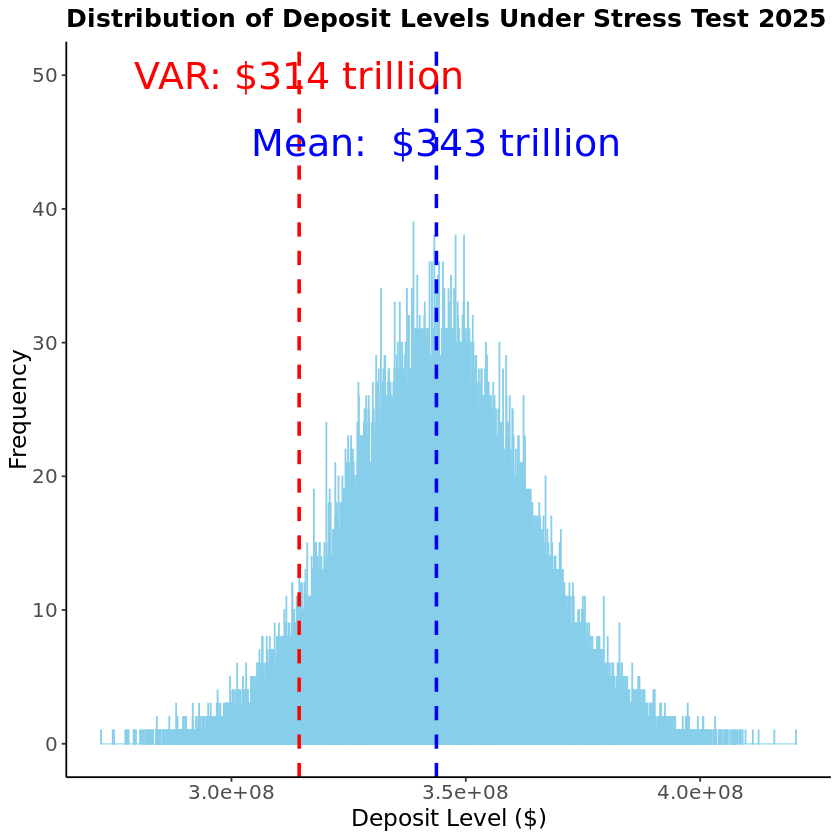

In [14]:

# Step 3: Define stress test parameters

drop_in_interest_rate <- 0.05  # 5% drop based mid 2007-to december 2028
sensitivity <- -0.591  # ($ 0.59 in billion)  A 1% change in federal rate leads to a $596,000,000 decline in deposits based on lm mode


# Step 4: Monte Carlo simulation
set.seed(42) # For reproducibility
num_simulations <- 100000
simulated_deposits <- numeric(num_simulations)
deposit_2025 <- 354271700 #(in thousands, from XGboost ==> 3.54 trillion)

for (i in 1:num_simulations) {
  random_factor <- rnorm(1, mean = 1 + sensitivity * drop_in_interest_rate, sd = 0.05) # Adjust standard deviation as needed
  simulated_deposits[i] <- deposit_2025 * random_factor
}

# Calculate statistics
mean_value <- mean(simulated_deposits)
VAR <- quantile(simulated_deposits, 0.05)

data <- data.frame(simulated_deposits)

# Plot
ggplot(data, aes(x = simulated_deposits)) +
  geom_histogram(binwidth = 10000, fill = "skyblue", color = "skyblue", alpha = 0.7) +
  geom_vline(xintercept = mean_value, color = "blue", linetype = "dashed", size = 1, label = "Mean") +
  geom_vline(xintercept = VAR, color = "red", linetype = "dashed", size = 1) +
  labs(
    title = "Distribution of Deposit Levels Under Stress Test 2025",
    x = "Deposit Level ($)",
    y = "Frequency"
  ) +
  annotate("text", x = mean_value, y = 45, label = ("Mean:  $343 trillion"), color = "blue", size = 8, face = "bold") +
  annotate("text", x = VAR, y = 50, label = ("VAR: $314 trillion"), color = "red", size = 8, face = "bold") +
  theme_classic() +
  theme(
    plot.title = element_text(size = 15, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12)
  )


In [11]:
VAR

5% 
314443197